<h1 align="center">drawing ground track of satellites
</h1>

<h2 align="center">Space mission analysis and design (AER4060)
</h2>
<h3 align="center">Dr:Mohammed Khalil Ibrahim
</h3>
<h3 align="center">by:Amr Ehab Abdelhamed Abdelfattah
</h3>
<h3 align="center">sec:1 bn:38
</h3>

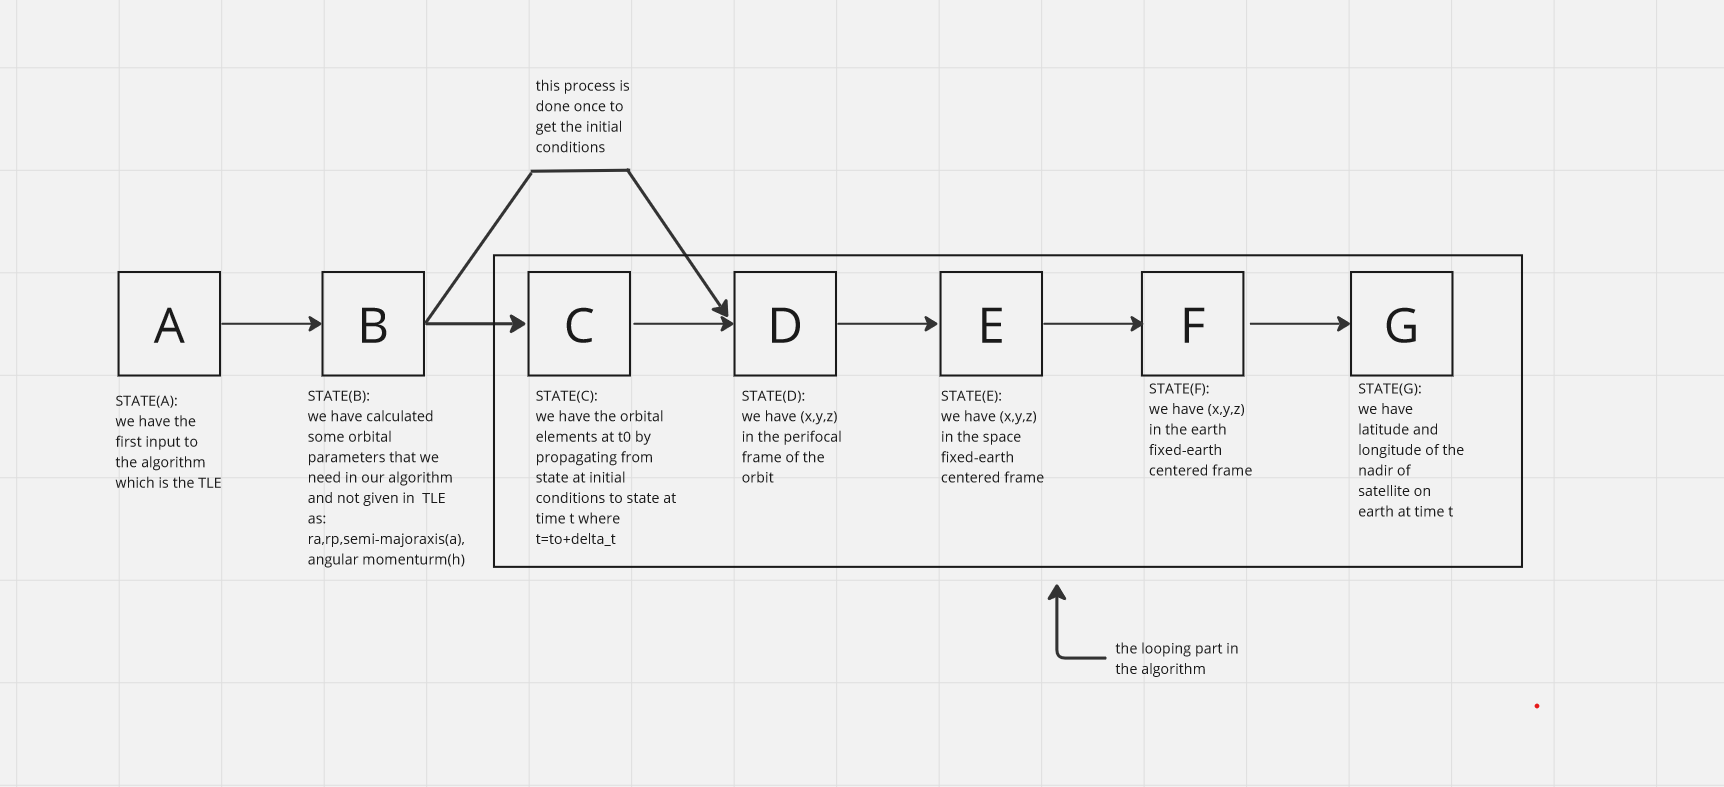

*******************************************
*******************************************

### section(1): importing modules and preparing the environment 

In [ ]:
#for rerunning the notebook on online platform like google colab which is prefered if python environment localy is not prepared
# run that cell to download and setup the SGP4 module 
#also you have to upload the coastlines.csv file as the map cant be drawn without it 
! pip install sgp4

In [7]:
#importing the needed modules for our work
import math         # this modules is used for mathematical operations as square root and trig functions
from math import sin,cos
import numpy as np  # this module is used for mathematical operations on vectors and matrices (arrays)
import datetime     #this module is used to handle the date and time formates as it provides a data tybe called datetime 

#all the following lines is importing from SGP4 module that we used as a verification for our work as shown later 
from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS
from astropy.time import Time
from sgp4.api import jday

### section(2): constructing functions that will help us in our work

In [12]:
#the following function describes the algorithm of conversion of orbital elements to x,y,z in fixed earth axis
def read_TLE(line1,line2):
    """this function for readint the two line element and extract orbital parameter from it then return this orbital 
    elemnts as a list
    """
    line1_str=line1.strip().split()
    IntDesignator=line1_str[2]
    epoch=line1_str[3]
    if line1_str[6][-2]=="-":
        temp_str=line1_str[6][-2:]
        converted_str=temp_str.replace("-", "E-")
        B_star=line1_str[6][:-2]+converted_str
    elif line1_str[6][-2]=="+" :
        temp_str=line1_str[6][-2:]
        converted_str=temp_str.replace("+", "E")
        B_star=line1_str[6][:-2]+converted_str    
        
    line2_str=line2.strip().split()
    inclination=line2_str[2]
    Asending_Node=line2_str[3]
    Eccentricity=line2_str[4]
    Argument_Pregiee=line2_str[5]
    Mean_anomely=line2_str[6]
    mean_motion=line2_str[7]

    return [float(B_star),float(inclination),float(Asending_Node),float('0.'+Eccentricity),float(Argument_Pregiee),float(Mean_anomely),float(mean_motion),epoch]



def Newton_solver(E_0,M,e):
    """this function solve the equation of E and M using newtons method"""
    E=E_0
    err=100000
    while(err>0.0001):
        E_1=E-(E-e*math.sin(E)-M)/(1-e*math.cos(E))
        err=E_1-E
        E=E_1
    return E



def transform(ar_pre,ri_as,inc):
    """this function return the transformation matrix that convert from perifocal to earth centered space fixed frame """
    ω=math.radians(ar_pre)
    Ω=math.radians(ri_as)
    i=math.radians(inc)
    trnasformation=np.array([[-sin(Ω)*cos(i)*sin(ω)+cos(Ω)*cos(ω) ,cos(Ω)*cos(i)*sin(ω)+sin(Ω)*cos(ω) ,sin(i)*sin(ω)],
    [-sin(Ω)*cos(i)*cos(ω)-cos(Ω)*sin(ω) ,cos(Ω)*cos(i)*cos(ω)-sin(Ω)*sin(ω) ,sin(i)*cos(ω)],
    [sin(Ω)*sin(i), -cos(Ω)*sin(i) ,cos(i)]])
    return  trnasformation



def from_orbital_to_cartisean(line1,line2):
    """this function was built for testing purposes to test our code and algorithm of finding the 
    position vector given the orbital element (process B and D-->G) against the sgp4 algorithm
    """
    mu=3.986004418*10**14
    orbital_elements=read_TLE(line1,line2)
    T=(1/orbital_elements[6])*24*60*60
    a=(T*math.sqrt(mu)/(2*math.pi))**(2/3)
    rp=a-a*orbital_elements[3]
    ra=2*a-rp
    h=math.sqrt(mu*rp*(1+orbital_elements[3]))
    E=Newton_solver(math.radians(orbital_elements[5]),math.radians(orbital_elements[5]),orbital_elements[3])
    true_anomaly=2*math.atan2((math.sqrt(1+orbital_elements[3])*math.sin(E/2)),(math.sqrt(1-orbital_elements[3])*math.cos(E/2)))
    #r_c=a*(1-orbital_elements[3]*math.cos(E))
    r_vect=(h**2/(mu*(1+orbital_elements[3]*cos(true_anomaly))))*np.array([math.cos(true_anomaly),math.sin(true_anomaly),0])
    R_vect=np.transpose(transform(orbital_elements[4],orbital_elements[2],orbital_elements[1]))@r_vect

    return R_vect
    
    


#### in the below this cell we define the two line elements of the satellite

In [13]:
s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991' #line1
t = '2 25544  51.6439 260.2001 0007417  17.6667  85.6398 15.50103472202482' #line2

#### in the next few cells we are going to test our algorithm of transformation to against SGP4 where the output is the state vector in space fixed earth centered frame

In [24]:
R=from_orbital_to_cartisean(s,t)/1000
R

array([4309.45770439,  852.46396285, 5182.93146372])

In [25]:
satellite = Satrec.twoline2rv(s, t)
jd, fr = jday(2019, 12, 9, 16, 38, 29)
e, r, v = satellite.sgp4(jd, fr)
r

(4306.884109690006, 851.0106783484183, 5176.336021116603)

#### as we can see the error is acceptable error and our code is working properly , the error may be due to the slighltly different definitions of the frames between our algorithm and the SGP4 algorithm

In [27]:
error=R-r
error

array([2.5735947 , 1.4532845 , 6.59544261])

### section(3):the groundtrack algorithm

In [5]:
def gen_ground_track(line1,line2,t_f):
    #define constans
    mu,j2,R=398600,0.0010836,6378
    #reading the two line elements
    orbital_elements=read_TLE(line1,line2)
    #[b_star inclination ascending_node essentricity argument_of_prigee mean_anomaly mean_motion epoch]
    T=(1/orbital_elements[6])*24*60*60
    a=(T*math.sqrt(mu)/(2*math.pi))**(2/3)
    rp=a-a*orbital_elements[3]
    ra=2*a-rp
    
    right_as_dot=-(1.5*(mu**0.5*j2*R**2)/((1-orbital_elements[3]**2)*a**(7/2)))*cos(math.radians(orbital_elements[1]))
    arg_pre_dot=right_as_dot*(2.5*(sin(math.radians(orbital_elements[1])))**2-2)/cos(math.radians(orbital_elements[1]))
    
    E=Newton_solver(math.radians(orbital_elements[5]),math.radians(orbital_elements[5]),orbital_elements[3])
    true_anomaly=2*math.atan2((math.sqrt(1+orbital_elements[3])*math.sin(E/2)),(math.sqrt(1-orbital_elements[3])*math.cos(E/2)))
    t_0=math.radians(orbital_elements[5])*T/(2*math.pi)
    h=math.sqrt(mu*rp*(1+orbital_elements[3]))
    r_vect=(h**2/(mu*(1+orbital_elements[3]*cos(true_anomaly))))*np.array([math.cos(true_anomaly),math.sin(true_anomaly),0])
    R_vect=np.transpose(transform(orbital_elements[4],orbital_elements[2],orbital_elements[1]))@r_vect
    x_pos=[R_vect[0]]
    y_pos=[R_vect[1]]
    z_pos=[R_vect[2]]
    t=0
    omega=7.2921159*10**-5
    earth_rot=np.array([[cos(omega*t-omega*t_0),sin(omega*t-omega*t_0),0],
                       [-sin(omega*t-omega*t_0),cos(omega*t-omega*t_0),0],
                       [0,0,1]])
    R_vect=earth_rot@R_vect
    R_vect_mag=math.sqrt(R_vect[0]**2+R_vect[1]**2+R_vect[2]**2)
    l,m,n=R_vect[0]/R_vect_mag,R_vect[1]/R_vect_mag,R_vect[2]/R_vect_mag
    lat=[math.asin(n)]
    if m>0:
        lon=[math.acos(l/cos(math.asin(n)))]
    elif m <=0:
        lon=[2*math.pi-math.acos(l/cos(math.asin(n)))]
                                                 
    for dt in range(1,t_f*60):
        t=t_0+dt
        M=2*math.pi*t/T
        E=Newton_solver(M,M,orbital_elements[3])
        true_anomaly=2*math.atan2((math.sqrt(1+orbital_elements[3])*math.sin(E/2)),(math.sqrt(1-orbital_elements[3])*math.cos(E/2)))
        right_as=math.radians(orbital_elements[2])+dt*right_as_dot
        arg_pre=math.radians(orbital_elements[4])+dt*arg_pre_dot
        r_vect=(h**2/(mu*(1+orbital_elements[3]*cos(true_anomaly))))*np.array([math.cos(true_anomaly),math.sin(true_anomaly),0])
        R_vect=np.transpose(transform(orbital_elements[4],orbital_elements[2],orbital_elements[1]))@r_vect
        earth_rot=np.array([[cos(omega*t-omega*t_0),sin(omega*t-omega*t_0),0],
                       [-sin(omega*t-omega*t_0),cos(omega*t-omega*t_0),0],
                       [0,0,1]])
        R_vect=earth_rot@R_vect
        x_pos.append(R_vect[0])
        y_pos.append(R_vect[1])
        z_pos.append(R_vect[2])
        R_vect_mag=math.sqrt(R_vect[0]**2+R_vect[1]**2+R_vect[2]**2)
        l,m,n=R_vect[0]/R_vect_mag,R_vect[1]/R_vect_mag,R_vect[2]/R_vect_mag
        lat.append(math.asin(n))
        if m>0:
            lon.append(math.acos(l/cos(math.asin(n))))
        elif m <=0:
            lon.append(2*math.pi-math.acos(l/cos(math.asin(n))))
    lon=[math.degrees(x) for x in lon]
    lon=[x-360 if x>180 else x for x in lon]
    lat=[math.degrees(x) for x in lat]
    return lon,lat


#### graphing the ground track on map

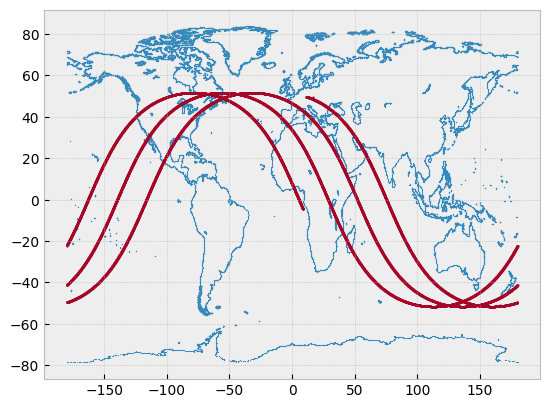

In [8]:
import matplotlib.pyplot as plt

coastline=np.genfromtxt("coastlines.csv", delimiter=',')
lon,lat=gen_ground_track(s,t,300)

plt.style.use('bmh')
plt.grid(linestyle="dotted")
plt.scatter(coastline[:,0], coastline[:,1],s=0.1)
plt.scatter(lon, lat,s=1)
plt.show()